# In this analysis, we are taking a set of peaks and finding those peaks that contain a motif

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import pybedtools
import pysam
import re
import urllib
import sqlite3
import random
from random import sample 
from collections import Counter
from tqdm import tnrange, tqdm_notebook
from xml.dom import minidom
from Bio import SeqIO
pd.set_option('display.max_colwidth', 1000)

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/inputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/'

In [3]:
slop = 0 
motif = ''

# Define our peak sites
- These may come from multiple sources. I'm trying to classify them according to how they were annotated (if they were annotated). 

In [4]:
# bed_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
# bed_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/211_01.basedon_211_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
# bed_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/205_01.basedon_205_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
# bed_file = '/home/bay001/projects/kris_apobec_20200121/reference_data/TIA1_Untreated_reproducible_peaks.bed.annotated_proxdist_miRlncRNA'
# bed_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/279_01.basedon_279_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
# bed_file = '/home/bay001/projects/jeevisha_stau2_20180314/permanent_data/02_annotate/inputs/764_01.basedon_764_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
# bed_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/seCLIP/seRBFOX2_A_01.basedon_seRBFOX2_A_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
# bed_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/Tia1_0ng_2_S41_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_c10.annotated'
# bed_file = '/home/bay001/projects/kris_apobec_20200121/reference_data/SLBP_K562_IDR.bed'
# bed_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/214_01.basedon_214_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
bed_file = '/home/bay001/projects/kris_apobec_20200121/reference_data/301.01v02.IDR.out.0102merged.bed.annotated_proxdist_miRlncRNA.blacklist_removed.bed'
# bed_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200331_293T_TIA1/IDR/TIA1/results/TIA1_reproducible_peaks.bed.annotated_proxdist_miRlncRNA'
assert os.path.exists(bed_file)
annotation_style = 'ericv2'
bed_file

'/home/bay001/projects/kris_apobec_20200121/reference_data/301.01v02.IDR.out.0102merged.bed.annotated_proxdist_miRlncRNA.blacklist_removed.bed'

### In order to read in multiple filetypes, we need to define the headers to parse out the appropriate information.

- ericv1 contains columns: ```['chrom','start','end','l10p','l2fc','strand','annotation','geneid']```
- ericv2 contains columns: ```['chrom','start','end','l10p','l2fc','strand','annotation','annotation2','geneid','genename','region_w_overlap']```
- brianv1 contains columns: ```['chrom','start','end','name','score','strand','geneid','genename','region','all_annotation']```

In [5]:
annotation_styles = {
    "ericv1":['chrom','start','end','l10p','l2fc','strand','annotation','geneid'],
    "ericv2":['chrom','start','end','l10p','l2fc','strand','annotation','annotation2','geneid','genename','region_w_overlap'],
    "brianv1":['chrom','start','end','name','score','strand','geneid','genename','region','all_annotation'],
    "inputnorm":['chrom','start','end','l10p','l2fc','strand'],
    "encodeidr":['chrom','start','end','name','score','strand']
}

def return_region(row, annotation_style='ericv1'):
    """ 
    Based on the way Eric or I output our annotations, let's re-format the region field to make it easier to parse out
    """
    try:
        if annotation_style=='ericv1':
            return row['annotation'].split('|')[0]
        elif annotation_style=='ericv2':
            return row['region_w_overlap'].split('|')[0]
        elif annotation_style=='brianv1':
            return row['region']
        elif annotation_style=='inputnorm' or annotation_style=='encodeidr':
            return 'unannotated'
    except IndexError:
        return 'intergenic'

def filter_peaks(df, l10p=3, l2fc=3):
    """
    If we get an unfiltered list of peaks, we need to filter for significance.
    """
    return df[(df['l10p']>=l10p) & (df['l2fc']>=l2fc)]

def read_filter_and_return_region(fn, annotation_style):
    """
    Reads in a list of peaks and filters them if needed.
    """
    df = pd.read_csv(fn, names=annotation_styles[annotation_style], sep='\t')
    print("BEFORE FILTERS", df.shape[0])
    df['region'] = df.apply(return_region, args=(annotation_style, ), axis=1)
    if 'l10p' in annotation_styles[annotation_style] and 'l2fc' in annotation_styles[annotation_style]:
        df = filter_peaks(df)
    print("AFTER FILTERS", df.shape[0])
    return df

peaks = read_filter_and_return_region(bed_file, annotation_style)
peaks.head()

BEFORE FILTERS 1781
AFTER FILTERS 1781


,chrom,start,end,l10p,l2fc,strand,annotation,annotation2,geneid,genename,region_w_overlap,region
0,chr8,95541294,95541362,6.645005,4.834668,-,CDS;ENSG00000164944.7,CDS||ENSG00000164944.7,ENSG00000164944.7,KIAA1429,5ss|3||CDS|65,5ss
1,chr9,139265319,139265390,3.015326,3.594934,-,CDS;ENSG00000187796.9,CDS||ENSG00000187796.9,ENSG00000187796.9,CARD9,CDS|71,CDS
2,chr6,43014683,43014769,9.796247,3.775442,-,noncoding_distintron;lncRNA|LINC00242||CDS;ENSG00000044090.4,CDS||ENSG00000044090.4,ENSG00000044090.4,CUL7,CDS|86,CDS
3,chr16,77225462,77225532,3.015326,3.887415,+,CDS;ENSG00000103111.10,CDS||ENSG00000103111.10,ENSG00000103111.10,MON1B,5ss|1||CDS|69,5ss
4,chr20,44599979,44600120,3.615838,4.101837,-,CDS;ENSG00000198026.6,CDS||ENSG00000198026.6,ENSG00000198026.6,ZNF335,CDS|71||3ss|20||5utr|50,CDS


### For STAMP data, we see the vast majority of peaks assigned to 3'UTR. So let's confirm and filter for only 3'UTR and CDS sites.

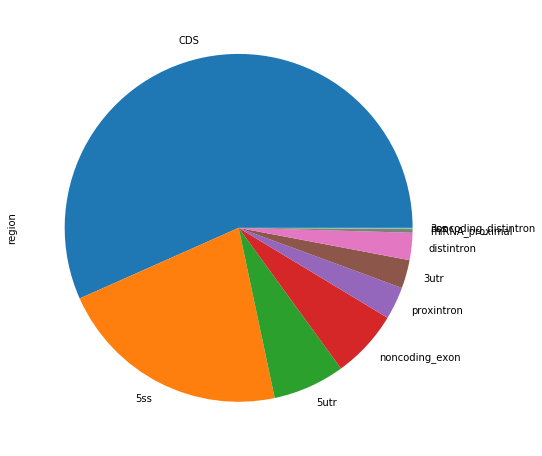

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
peaks['region'].value_counts().plot(kind='pie', ax=ax)

In [7]:
if 'unannotated' in peaks['region'].value_counts():
    pass
else:
    peaks = peaks[(peaks['region']=='3utr') | (peaks['region']=='CDS')]
print(peaks.shape[0])
peaks.head()

1056


,chrom,start,end,l10p,l2fc,strand,annotation,annotation2,geneid,genename,region_w_overlap,region
1,chr9,139265319,139265390,3.015326,3.594934,-,CDS;ENSG00000187796.9,CDS||ENSG00000187796.9,ENSG00000187796.9,CARD9,CDS|71,CDS
2,chr6,43014683,43014769,9.796247,3.775442,-,noncoding_distintron;lncRNA|LINC00242||CDS;ENSG00000044090.4,CDS||ENSG00000044090.4,ENSG00000044090.4,CUL7,CDS|86,CDS
4,chr20,44599979,44600120,3.615838,4.101837,-,CDS;ENSG00000198026.6,CDS||ENSG00000198026.6,ENSG00000198026.6,ZNF335,CDS|71||3ss|20||5utr|50,CDS
5,chr20,2635571,2635593,5.759827,3.341600,+,CDS;ENSG00000101361.10,CDS||ENSG00000101361.10,ENSG00000101361.10,NOP56,CDS|22,CDS
7,chr17,4443053,4443157,5.162591,3.572390,-,noncoding_distintron;lncRNA|LHX1-DT||noncoding_distintron;lncRNA|MAPT-AS1||CDS;ENSG00000132382.10,CDS||ENSG00000132382.10,ENSG00000132382.10,MYBBP1A,CDS|104,CDS


# get the fasta sequences and check for existence of motif

## Convert our filtered peaks to BedTool objects.

In [8]:
genome_fasta = '/projects/ps-yeolab3/bay001/annotations/hg19/hg19.fa'
chrom_sizes = '/projects/ps-yeolab3/bay001/annotations/hg19/hg19.chrom.sizes'

def get_peak_interval_from_annotated_dataframe(df, slop, chrom_sizes=None):
    """ 
    Returns a bedtool from a peaks dataframe. 
    Peaks dataframe is basically a df can come from an "eric-annotated" or "brian-annotated" file so as long as it contains the correct fields. 
    """
    bedtool = []
    for row in df.iterrows():
        try:
            interval = pybedtools.create_interval_from_list([row[1]['chrom'], int(row[1]['start']), int(row[1]['end']), row[1]['geneid'], "0", row[1]['strand']])
        except KeyError:
            interval = pybedtools.create_interval_from_list([row[1]['chrom'], int(row[1]['start']), int(row[1]['end']), row[1]['l2fc'], "0", row[1]['strand']])
        bedtool.append(interval)
    bedtool = pybedtools.BedTool(bedtool).sort()
    bedtool = bedtool.slop(b=slop, g=chrom_sizes)
    print("size prior to merge: {}".format(bedtool.to_dataframe().shape[0]))
    bedtool = bedtool.merge(c=(4,5,6), s=True, o=('collapse','collapse','distinct'))
    print("size after merge: {}".format(bedtool.to_dataframe().shape[0]))
    return bedtool

# utr3_bedtool is a bedtool-ified version of the annotated dataframe for JUST 3'UTR peaks.
peaks_bedtool = get_peak_interval_from_annotated_dataframe(peaks, slop=slop, chrom_sizes=chrom_sizes)
# assert peaks_bedtool.to_dataframe().shape[0] == peaks.shape[0]

size prior to merge: 1056
size after merge: 911


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [9]:
def record_id_to_coords(id_string):
    """ 
    Turns a seqrecord fasta id into coordinates.
    seqrecord fasta ids (stranded) look like this:
    
    chr11:1774028-1774186(-)
    
    """
    chrom, pos = id_string.split(':')
    coord, strand = pos.split('(')
    strand = strand.replace(')','')
    start, end = coord.split('-')
    try:
        assert (strand == '+') or (strand == '-')
    except AssertionError:
        print("Strand not correct: [{}]".format(strand))
        return 1
    return chrom, int(start), int(end), strand

# Get the sequence from the 3'UTR peaks and save them. This will report strand-specific, so negative stranded coordinates will return the reverse complement. 

In [10]:
def write_peaks_as_fasta(bedtool, genome_fa, output_fasta):
    """
    Writes peaks as strand-specific FASTA sequences. 
    s=True means we will be returning the reverse complement 
    sequence for negative strand peaks.
    """
    seq_bedtool = bedtool.sequence(fi=genome_fa, s=True)
    with open(output_fasta, 'w') as f:
        f.write(open(seq_bedtool.seqfn).read())

output_fasta = os.path.join(output_dir, os.path.splitext(os.path.basename(bed_file))[0] + ".fasta")

write_peaks_as_fasta(
    bedtool=peaks_bedtool,
    genome_fa=genome_fasta,
    output_fasta=output_fasta
)

# sanity check - make sure there is a significant portion of peaks that contain the motif.

In [11]:
def reverse_complement(seq):
    """ 
    Returns the reverse complement of a sequence. 
    """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a': 't', 'c': 'g', 'g': 'c', 't': 'a'} 
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases

def write_peaks_with_motif(peaks, peaks_w_motif):
    """
    This function assumes negative stranded sequences are reverse-complemented. 
    @see write_peaks_as_fasta()
    """
    with_motif_counter = 0
    without_motif_counter = 0
    
    with open(peaks_w_motif, 'w') as o:
        with open(peaks, 'r') as f:
            for line in f:
                if line.startswith('>'):
                    chrom, start, end, strand = record_id_to_coords(line[1:].rstrip())
                else:
                    if strand == '+' or strand == '-':
                        if line.upper().find(motif) != -1:
                            o.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(chrom, start, end, line.rstrip(), '0', strand))
                            with_motif_counter += 1
                        else:
                            without_motif_counter += 1
                    else:
                        print('strand not correct: [{}]'.format(strand))
    print("Peaks with motif: {}. Peaks WITHOUT motif: {}".format(with_motif_counter, without_motif_counter))
    return with_motif_counter, without_motif_counter

with_motif_counter, without_motif_counter = write_peaks_with_motif(
    os.path.join(output_dir, os.path.splitext(os.path.basename(bed_file))[0] + ".fasta"),
    os.path.join(output_dir, os.path.splitext(os.path.basename(bed_file))[0] + ".with.{}.bed".format(motif))
)

Peaks with motif: 911. Peaks WITHOUT motif: 0


# Make sure every sequence we have has the motif.

In [12]:
def return_sequence_records_with_motif(fn, motif):
    """
    Returns a SeqIO record of sequences containing the motif. We expect this 
    FASTA file to contain the reverse-complement sequences if negative strand. 
    We also expect the FASTA headers to contain strand info 
    @see BedTool.sequence(fi=hg19.fa, s=True)
    """
    seqs_with_motif = []
    with open(fn, 'r') as f:
        for record in SeqIO.parse(f, "fasta"):
            chrom, start, end, strand = record_id_to_coords(record.id)
            if (strand == '+' or strand =='-') and str(record.seq).upper().find(motif) != -1:
                seqs_with_motif.append(record)
            else:
                assert strand == '+' or strand == '-'
    return seqs_with_motif

seqs_with_motif = return_sequence_records_with_motif(fn=os.path.join(output_dir, os.path.splitext(os.path.basename(bed_file))[0] + ".with.{}.bed".format(motif)), motif=motif)

# Make sure every region describes a motif

for record in seqs_with_motif:
    try:
        record_upper = record.seq.upper()
        assert record_upper[record_upper.find(motif):record_upper.find(motif)+len(motif)] == motif
    except AssertionError:
        print(record)

# plot something nice

Text(0.5, 1.1, 'Peaks in regions with/without a motif')

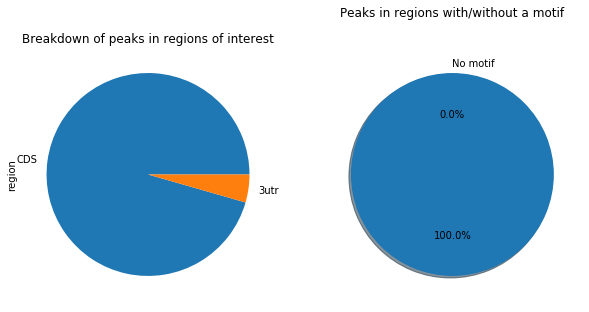

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
peaks['region'].value_counts().plot(kind='pie', ax=axs[0])
axs[1].pie([with_motif_counter, without_motif_counter], labels=['{}'.format(motif),'No motif'],
        autopct='%1.1f%%', shadow=True, startangle=90)

axs[0].set_title("Breakdown of peaks in regions of interest")
axs[1].set_title("Peaks in regions with/without a motif", y=1.1)